In [209]:
import numpy as np

In [210]:
import scipy.io
mat = scipy.io.loadmat('laser.mat') # load mat file
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Dec 07 12:35:22 2010',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[29.8509 , 25.7777 , 28.8859 , ...,  9.65777,  5.58567,  9.82632],
        [26.2727 , 31.2289 , 29.7408 , ...,  5.36246,  6.94501,  7.90108],
        [34.179  , 27.0398 , 29.3324 , ..., 14.4956 , 16.8671 , 18.7888 ],
        ...,
        [35.8083 , 31.0808 , 24.7077 , ..., 16.7864 ,  7.77301, 12.6472 ],
        [33.9818 , 27.2921 , 23.285  , ...,  5.35315,  6.88335, -2.805  ],
        [33.3759 , 25.4986 , 31.0451 , ..., 22.5099 , 19.8174 , 20.6888 ]]),
 'Y': array([[-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [-

In [211]:
X = np.array(mat['X'])
y = np.array( mat['Y'].reshape(200)) # make y 1-dimensional
print(X.shape)
print(y.shape)

(200, 60)
(200,)


Next it is useful to print some of the data as graphs.

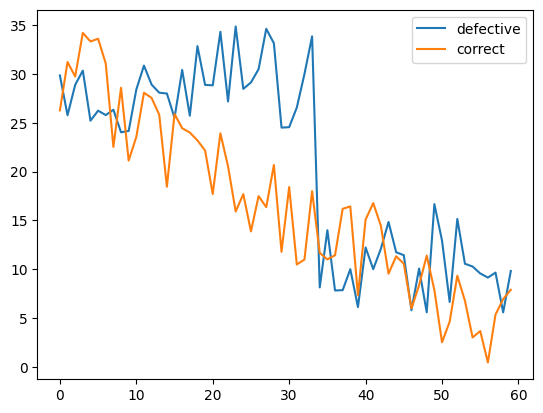

In [212]:
import matplotlib.pyplot as plt
import numpy as np

t = [*range(0, X.shape[1])]
plt.plot(t, X[0], label="defective")
plt.plot(t, X[1], label="correct")
plt.legend()

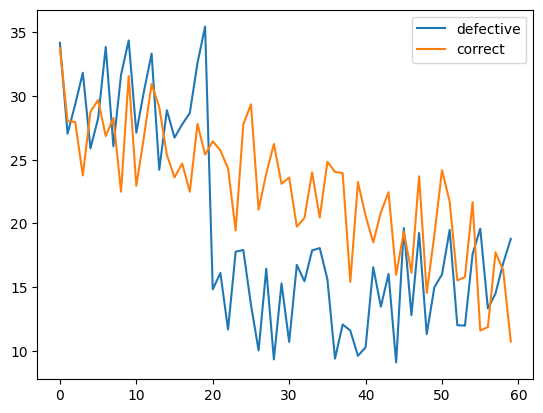

In [213]:
plt.plot(t, X[2], label="defective")
plt.plot(t, X[3], label="correct")
plt.legend()

In [214]:
pos = 0
neg = 0
for classification in y:
    if(classification == 1):
        pos+=1
    else:
        neg+=1

print(f"{float(pos/len(y))}% are working.")
print(f"{float(neg/len(y))}% are not working.")

0.5% are working.
0.5% are not working.


Scipy Kernels

In [215]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def nested_cv(estimator, X, y, k, p_grid):
   outer_cv = KFold(n_splits=k, random_state=0, shuffle=True)
   inner_cv = KFold(n_splits=k, random_state=0, shuffle=True)

   clf = GridSearchCV(estimator=estimator, param_grid=p_grid, cv=inner_cv)
   
   mean_nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv).mean() # has size of k
   res = clf.fit(X, y)
   best_model = res.best_estimator_
   mean_test_scores = res.cv_results_['mean_test_score']

   return mean_nested_score, best_model, mean_test_scores

In [216]:
def remove_not_equally_sized_entries(array):
    cleaned_array = []
    most_common_entry_length = get_most_common_entry_size(array)
    for list in array:
        if len(list) == most_common_entry_length:
            cleaned_array.append(list)

    return cleaned_array

def get_most_common_entry_size(array): 
    entry_counts = {}
    for entry in array:
        if (len(entry)) in entry_counts:
            entry_counts[len(entry)] += 1
        else:
            entry_counts[len(entry)] = 1
    
    biggest_entry_index = None
    biggest_entry_index_length = 0
    for (key, entry) in entry_counts.items():
        if(entry > biggest_entry_index_length):
            biggest_entry_index_length = entry
            biggest_entry_index = key

    return biggest_entry_index

In [217]:
def mean_array(_2d_array):
    _1d_array = []
    for i in range(len(_2d_array[0])):
        values_for_mean = []
        for j in range(len(_2d_array)):
            values_for_mean.append(_2d_array[j][i])
        _1d_array.append(np.mean(values_for_mean))
    return _1d_array
        

In [218]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
from numpy import interp

def k_fold_evaluation(model, X, y, k):
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    f1_scores = []

    k_fold = KFold(n_splits=k, random_state=0, shuffle=True)

    mean_fprs = np.linspace(0,1,101)

    for i, (i_train, i_test) in enumerate(k_fold.split(X)) :
        clf = model.fit(X[i_train], y[i_train])
        y_pred = clf.predict(X[i_test])
        y_score = clf.predict_proba(X[i_test])

        precision, recall, _ = precision_recall_curve(y[i_test], y_pred)
        fpr, tpr, _ = roc_curve(y[i_test], y_score[:,1])
        precisions.append(precision)
        recalls.append(recall)
        tprs.append(interp(mean_fprs, fpr, tpr))
        f1_scores.append(f1_score(y[i_test], y_pred))   

    precisions = remove_not_equally_sized_entries(precisions)
    recalls = remove_not_equally_sized_entries(recalls)

    mean_tprs = np.mean(tprs, axis=0)
    mean_tprs[0] = 0

    return mean_array(precisions), mean_array(recalls), mean_fprs, mean_tprs, np.mean(f1_scores) # mean of 2d array is a number!...should be 1d array

In [219]:
from matplotlib.pyplot import scatter
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import hinge_loss
from sklearn import preprocessing

def train_and_evaluate(X, y, kernel, C=1, degree=2):

    train_risks = []
    test_risks = []
    train_accs = []
    test_accs = []
    k = 20
    kf = KFold(n_splits=k, random_state=None, shuffle=False)

    for i, (i_train, i_test) in enumerate(kf.split(X=X, y=y)):

        # Train the SVC
        if(kernel=="poly"):

            clf = svm.SVC(kernel=kernel, C=C, degree=degree).fit(X[i_train], y[i_train])
            y_train_pred = clf.predict(X[i_train])
            y_test_pred = clf.predict(X[i_test])
            
        else:
            clf = svm.SVC(kernel=kernel, C=C).fit(X[i_train], y[i_train])
            y_train_pred = clf.predict(X[i_train])
            y_test_pred = clf.predict(X[i_test])

        train_accs.append(accuracy_score(y[i_train], y_train_pred))
        test_accs.append(accuracy_score(y[i_test], y_test_pred))

        train_risks.append(hinge_loss(y_true=y[i_train], pred_decision=y_train_pred))
        test_risks.append(hinge_loss(y_true=y[i_test], pred_decision=y_test_pred))



    if(kernel=="poly"):
        clf = svm.SVC(kernel=kernel, C=C, degree=degree).fit(X, y)
        y_pred_overall = clf.predict(X)
    else:
        clf = svm.SVC(kernel=kernel, C=C).fit(X, y)
        y_pred_overall = clf.predict(X)

    overall_risk = hinge_loss(y_true=y, pred_decision=y_pred_overall)

    return np.mean(train_accs), np.mean(test_accs), np.mean(train_risks), np.mean(test_risks), overall_risk

In [220]:
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.model_selection import train_test_split

log_scale = np.linspace(-7, 2, 37)
Cs = [10**f for f in log_scale]

poly_degrees = [int(n) for n in np.linspace(2,5,4)]

lin_test_accs = []
poly_test_accs = []
rbf_test_accs = []
sigmoid_test_accs = []
lin_train_accs = []
poly_train_accs = []
rbf_train_accs = []
sigmoid_train_accs = []
lin_train_emp_risks = []
poly_train_emp_risks = []
rbf_train_emp_risks = []
sigmoid_train_emp_risks = []
lin_test_emp_risks = []
poly_test_emp_risks = []
rbf_test_emp_risks = []
sigmoid_test_emp_risks = []
lin_overall_risks = []
poly_overall_risks = []
rbf_overall_risks = []
sigmoid_overall_risks = []

for i, C in enumerate(Cs):
    lin_train_acc, lin_test_acc, lin_train_emp_risk, lin_test_emp_risk, lin_overall_risk = train_and_evaluate(X, y, "linear", C=C)
    lin_train_accs.append(lin_train_acc)
    lin_test_accs.append(lin_test_acc)
    lin_train_emp_risks.append(lin_train_emp_risk)
    lin_test_emp_risks.append(lin_test_emp_risk)
    lin_overall_risks.append(lin_overall_risk)
    
    rbf_train_acc, rbf_test_acc, rbf_train_emp_risk, rbf_test_emp_risk, rbf_overall_risk = train_and_evaluate(X, y, "rbf", C=C)
    rbf_train_accs.append(rbf_train_acc)
    rbf_test_accs.append(rbf_test_acc)
    rbf_train_emp_risks.append(rbf_train_emp_risk)
    rbf_test_emp_risks.append(rbf_test_emp_risk)
    rbf_overall_risks.append(rbf_overall_risk)
    
for d in poly_degrees:
    poly_train_acc, poly_test_acc, poly_train_emp_risk, poly_test_emp_risk, poly_overall_risk = train_and_evaluate(X, y, "poly", C=1, degree=(int(d)))
    poly_train_accs.append(poly_train_acc)
    poly_test_accs.append(poly_test_acc)
    poly_train_emp_risks.append(poly_train_emp_risk)
    poly_test_emp_risks.append(poly_test_emp_risk)
    poly_overall_risks.append(poly_overall_risk)

In [221]:
lin_svm = svm.SVC(kernel="linear", probability=True)
lin_nested_cv, lin_best_model, lin_test_scores = nested_cv(lin_svm, X, y, 20, {"C": Cs})
lin_precision, lin_recall, lin_fpr, lin_tpr, lin_f1_score = k_fold_evaluation(lin_best_model, X, y, 20)


In [222]:
poly_svm = svm.SVC(kernel="poly", probability=True)
poly_nested_cv, poly_best_model, poly_test_scores = nested_cv(poly_svm, X, y, 20, {"degree": poly_degrees})
poly_precision, poly_recall, poly_fpr, poly_tpr, poly_f1_score = k_fold_evaluation(poly_best_model, X, y, 20)


In [223]:
rbf_svm = svm.SVC(kernel="rbf", probability=True)
rbf_nested_cv, rbf_best_model, rbf_test_scores = nested_cv(rbf_svm, X, y, 20, {"C": Cs})
rbf_precision, rbf_recall, rbf_fpr, rbf_tpr, rbf_f1_score = k_fold_evaluation(rbf_best_model, X, y, 20)


In [238]:
print(f"Nested CV score for linear Kernel: {lin_nested_cv}")
print(f"Nested CV score for polynomial Kernel: {poly_nested_cv}")
print(f"Nested CV score for RBF Kernel: {rbf_nested_cv}")

Nested CV score for linear Kernel: 0.9800000000000001
Nested CV score for polynomial Kernel: 0.9650000000000001
Nested CV score for RBF Kernel: 0.985


Best test accuracy for linear is 0.9799999999999999 with C = 0.00017782794100389227
Best test accuracy for polynomial is 0.97 with C = 1e-07
Best test accuracy for rbf is 0.99 with C = 1.7782794100389228
Least Empirical risk for linear is 0.04 with C = 0.00017782794100389227 and overall risk of: 0.03
Least Empirical risk for polynomial is 0.06 with degree = 2 and overall risk of: 0.0
Least Empirical risk for rbf is 0.02 with C = 1.7782794100389228 and overall risk of: 0.0


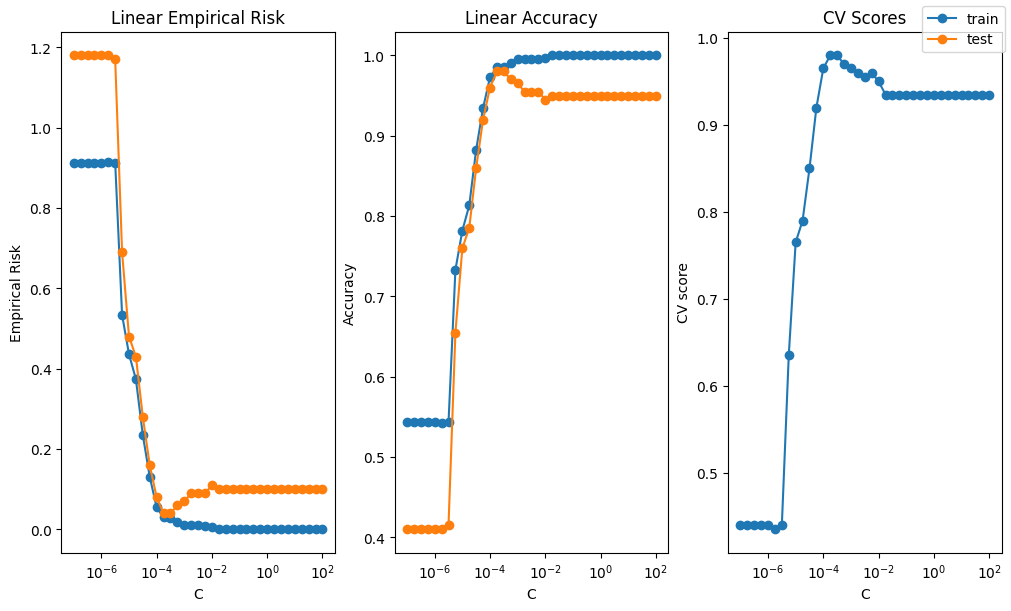

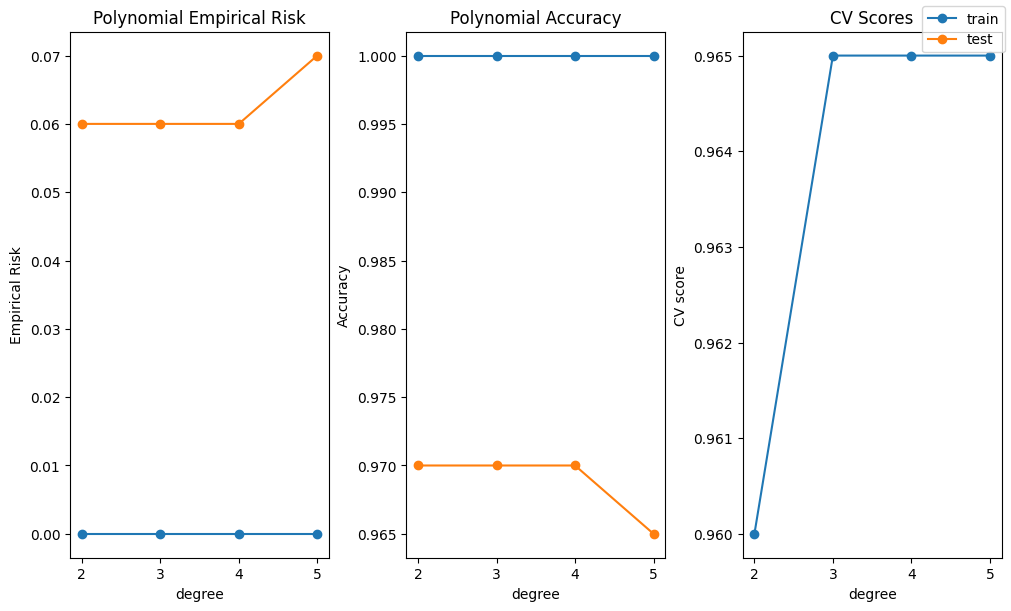

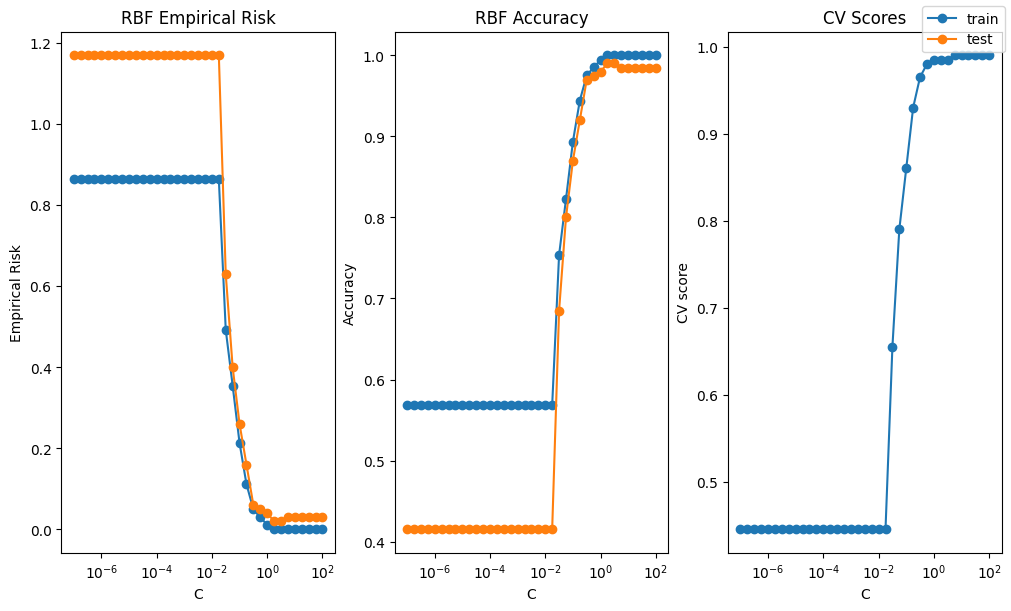

In [237]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

print(f"Best test accuracy for linear is {max(lin_test_accs)} with C = { Cs[np.argmax(lin_test_accs)]}")
print(f"Best test accuracy for polynomial is {max(poly_test_accs)} with C = { Cs[np.argmax(poly_test_accs)]}")
print(f"Best test accuracy for rbf is {max(rbf_test_accs)} with C = { Cs[np.argmax(rbf_test_accs)]}")

print(f"Least Empirical risk for linear is {min(lin_test_emp_risks)} with C = { Cs[np.argmin(lin_test_emp_risks)]} and overall risk of: {lin_overall_risks[np.argmin(lin_test_emp_risks)]}")
print(f"Least Empirical risk for polynomial is {min(poly_test_emp_risks)} with degree = { poly_degrees[np.argmin(poly_test_emp_risks)]} and overall risk of: {poly_overall_risks[np.argmin(poly_test_emp_risks)]}")
print(f"Least Empirical risk for rbf is {min(rbf_test_emp_risks)} with C = { Cs[np.argmin(rbf_test_emp_risks)]} and overall risk of: {rbf_overall_risks[np.argmin(rbf_test_emp_risks)]}")

fig_1, axs_1 = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')

axs_1.flat[0].set_title("Linear Empirical Risk")
axs_1.flat[0].plot(Cs, lin_train_emp_risks, 'o-', label="train")
axs_1.flat[0].plot(Cs, lin_test_emp_risks, 'o-', label="test")
axs_1.flat[0].set_xlabel("C")
axs_1.flat[0].set_ylabel("Empirical Risk")
axs_1.flat[0].set_xscale("log")
axs_1.flat[1].set_title("Linear Accuracy")
axs_1.flat[1].plot(Cs, lin_train_accs, 'o-')
axs_1.flat[1].plot(Cs, lin_test_accs, 'o-')
axs_1.flat[1].set_xscale("log")
axs_1.flat[1].set_xlabel("C")
axs_1.flat[1].set_ylabel("Accuracy")
axs_1.flat[2].set_title("CV Scores")
axs_1.flat[2].plot(Cs, lin_test_scores, 'o-')
axs_1.flat[2].set_xscale("log")
axs_1.flat[2].set_xlabel("C")
axs_1.flat[2].set_ylabel("CV score")


fig_2, axs_2 = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')


axs_2.flat[0].set_title("Polynomial Empirical Risk")
axs_2.flat[0].plot(poly_degrees, poly_train_emp_risks, 'o-', label="train")
axs_2.flat[0].plot(poly_degrees, poly_test_emp_risks, 'o-', label="test")
axs_2.flat[0].set_xlabel("degree")
axs_2.flat[0].set_ylabel("Empirical Risk")
axs_2.flat[1].set_title("Polynomial Accuracy")
axs_2.flat[1].plot(poly_degrees, poly_train_accs, 'o-')
axs_2.flat[1].plot(poly_degrees, poly_test_accs, 'o-')
axs_2.flat[1].set_xlabel("degree")
axs_2.flat[1].set_ylabel("Accuracy")
axs_2.flat[2].set_title("CV Scores")
axs_2.flat[2].plot(poly_degrees, poly_test_scores, 'o-')
axs_2.flat[2].set_xlabel("degree")
axs_2.flat[2].set_ylabel("CV score")


fig_3, axs_3 = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')

axs_3.flat[0].set_title("RBF Empirical Risk")
axs_3.flat[0].plot(Cs, rbf_train_emp_risks, 'o-', label="train")
axs_3.flat[0].plot(Cs, rbf_test_emp_risks, 'o-', label="test")
axs_3.flat[0].set_xscale("log")
axs_3.flat[0].set_xlabel("C")
axs_3.flat[0].set_ylabel("Empirical Risk")
axs_3.flat[1].set_title("RBF Accuracy")
axs_3.flat[1].plot(Cs, rbf_train_accs, 'o-')
axs_3.flat[1].plot(Cs, rbf_test_accs, 'o-')
axs_3.flat[1].set_xscale("log")
axs_3.flat[1].set_xlabel("C")
axs_3.flat[1].set_ylabel("Accuracy")
axs_3.flat[2].set_title("CV Scores")
axs_3.flat[2].plot(Cs, rbf_test_scores, 'o-')
axs_3.flat[2].set_xscale("log")
axs_3.flat[2].set_xlabel("C")
axs_3.flat[2].set_ylabel("CV score")

fig_1.legend()
fig_2.legend()
fig_3.legend()



Precision/Recall + ROC

In [226]:
print(f"linear f1 score: {lin_f1_score}")
print(f"polynomial f1 score: {poly_f1_score}")
print(f"rbf f1 score: {rbf_f1_score}")


linear f1 score: 0.9766233766233766
polynomial f1 score: 0.9592671217671217
rbf f1 score: 0.9857142857142858


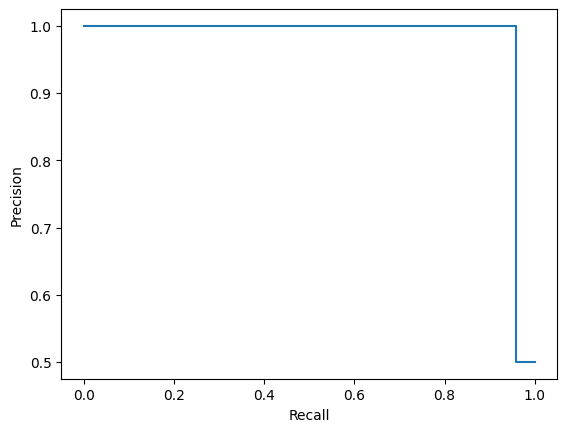

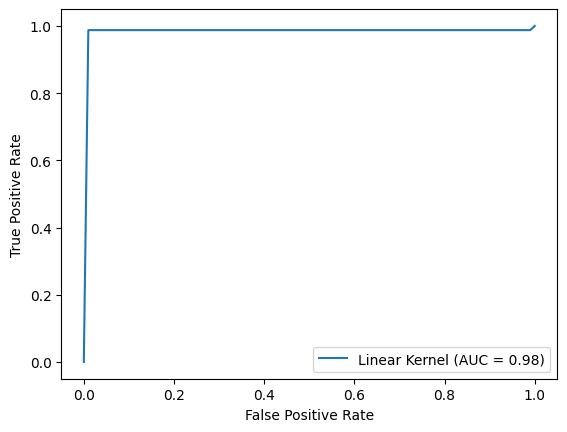

In [227]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

display = PrecisionRecallDisplay(recall=lin_recall, precision=lin_precision)
display.plot()

lin_auc = auc(lin_fpr, lin_tpr)
roc_display = RocCurveDisplay(fpr=lin_fpr, tpr=lin_tpr, roc_auc = lin_auc, estimator_name="Linear Kernel").plot()

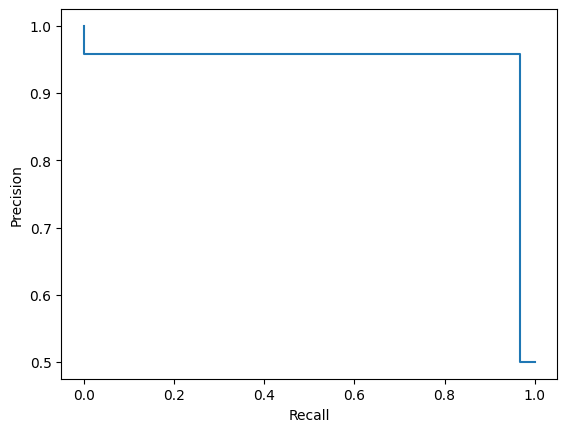

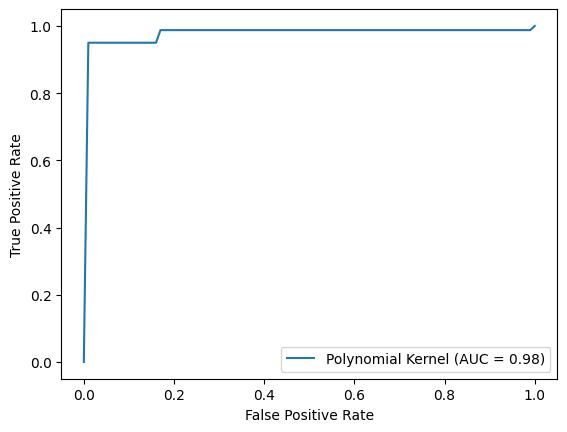

In [228]:
display = PrecisionRecallDisplay(recall=poly_recall, precision=poly_precision)
display.plot()
poly_auc = auc(poly_fpr, poly_tpr)
roc_display = RocCurveDisplay(fpr=poly_fpr, tpr=poly_tpr, roc_auc = poly_auc, estimator_name="Polynomial Kernel").plot()

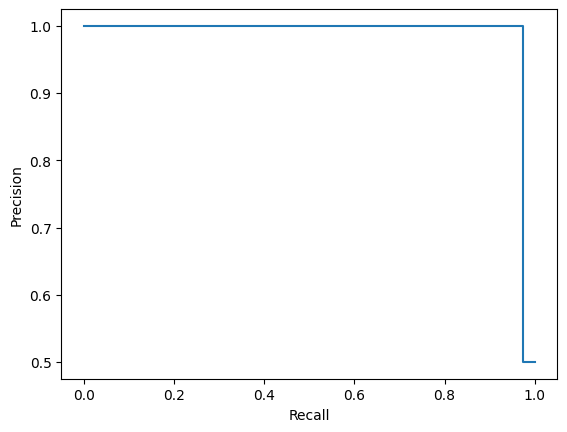

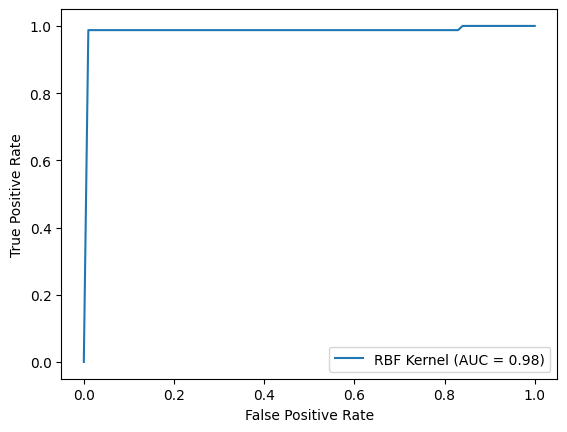

In [229]:
display = PrecisionRecallDisplay(recall=rbf_recall, precision=rbf_precision)
display.plot()
rbf_auc = auc(rbf_fpr, rbf_tpr)
roc_display = RocCurveDisplay(fpr=rbf_fpr, tpr=rbf_tpr, roc_auc = rbf_auc, estimator_name="RBF Kernel").plot()


## RandomForest

In [231]:
from sklearn.ensemble import RandomForestClassifier

def rf_evaluation(X_train, y_train, X_test, y_test, n_estimators=None, max_depth=None, random_state=0):

    if(n_estimators is not None):
        if(max_depth is not None):
            clf = RandomForestClassifier(n_estimators, max_depth=max_depth, random_state=random_state)
        else:
            clf = RandomForestClassifier(n_estimators, random_state=random_state)
    else:
        if(max_depth is not None):
            clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
        else:
            clf = RandomForestClassifier(random_state=random_state)

    clf.fit(X_train, y_train)
    y_train_predict = clf.predict(X_train)
    y_test_predict = clf.predict(X_test)

    return accuracy_score(y_train, y_train_predict), accuracy_score(y_test, y_test_predict), hinge_loss(y_train, y_train_predict), hinge_loss(y_test, y_test_predict)

def k_fold_rf(X, y, k, n_estimators=None, max_depth=None, random_state=0):
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []
    cv = KFold(k, shuffle=False)
    for (i_train, i_test) in cv.split(X):
        train_acc, test_acc, train_loss, test_loss = rf_evaluation(X[i_train], y[i_train], X[i_test], y[i_test], n_estimators, max_depth, random_state)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return np.mean(train_accs), np.mean(test_accs), np.mean(train_losses), np.mean(test_losses)

In [232]:
from matplotlib import pyplot as plt

lin_count = [int(n) for n in np.linspace(1, 10, num=10)]
sqr_count = [int(n) for n in np.linspace(4, 15, num=12)**2]

n_estimators = lin_count + sqr_count

train_accuracies_random_forest = []
test_accuracies_random_forest = []
train_emp_risk_random_forest = []
test_emp_risk_random_forest = []

for n_est in n_estimators:
    train_accs, test_accs, train_losses, test_losses = k_fold_rf(X, y, 20, n_estimators=n_est)
    train_accuracies_random_forest.append(train_accs)
    test_accuracies_random_forest.append(test_accs)
    train_emp_risk_random_forest.append(train_losses)
    test_emp_risk_random_forest.append(test_losses)

max_train_acc_rf_index = np.argmax(train_accuracies_random_forest)
print("Highest Training Accuracy with number of estimators {}: {}".format(n_estimators[max_train_acc_rf_index], train_accuracies_random_forest[max_train_acc_rf_index]))
max_test_acc_rf = max(test_accuracies_random_forest)
index_best_rf = test_accuracies_random_forest.index(max_test_acc_rf)
print("Highest Test Accuracy with number of estimators = {}: {}".format(n_estimators[index_best_rf], max_test_acc_rf))

Highest Training Accuracy with number of estimators 25: 1.0
Highest Test Accuracy with number of estimators = 100: 0.975


In [234]:
rf_clf = RandomForestClassifier()
rf_nested_cv, rf_best_model, rf_test_scores = nested_cv(rf_clf, X, y, 10, {"n_estimators": n_estimators})
rf_precision, rf_recall, rf_fpr, rf_tpr, rf_f1_score = k_fold_evaluation(rf_best_model, X, y, 20)

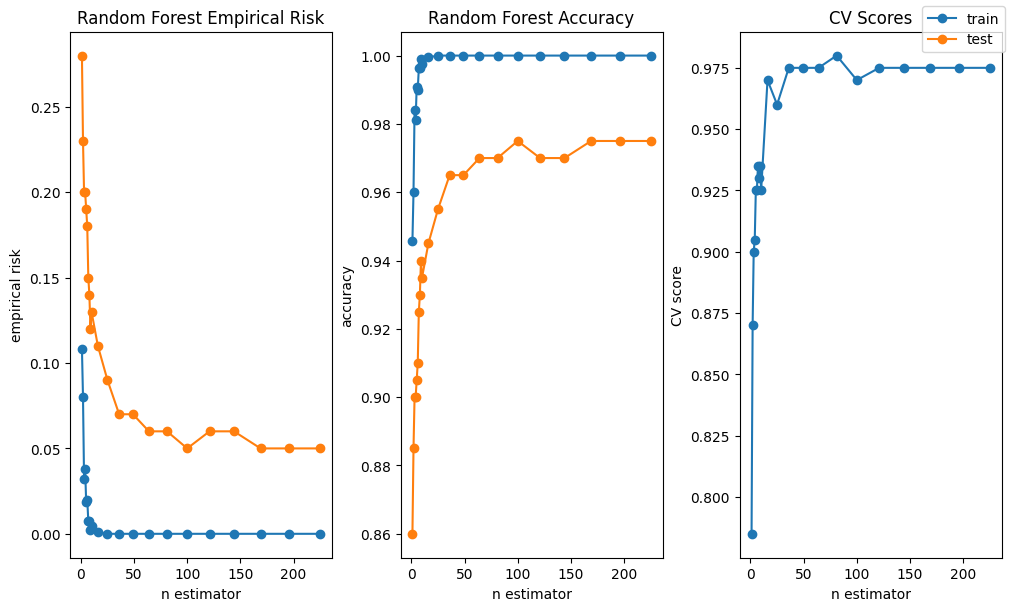

In [235]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')

axs.flat[0].set_title("Random Forest Empirical Risk")
axs.flat[0].plot(n_estimators, train_emp_risk_random_forest, 'o-', label="train")
axs.flat[0].plot(n_estimators, test_emp_risk_random_forest, 'o-', label="test")
axs.flat[0].set_xlabel("n estimator")
axs.flat[0].set_ylabel("empirical risk")
axs.flat[1].set_title("Random Forest Accuracy")
axs.flat[1].plot(n_estimators, train_accuracies_random_forest, 'o-')
axs.flat[1].plot(n_estimators, test_accuracies_random_forest, 'o-')
axs.flat[1].set_xlabel("n estimator")
axs.flat[1].set_ylabel("accuracy")
axs.flat[2].set_title("CV Scores")
axs.flat[2].plot(n_estimators, rf_test_scores, 'o-')
axs.flat[2].set_xlabel("n estimator")
axs.flat[2].set_ylabel("CV score")
fig.legend()

Least Empirical risk for rbf is 0.05 with number of estimators = 100
Nested CV score for Random Forest: 0.9649999999999999
Random Forest f1 score: 0.9756132756132756


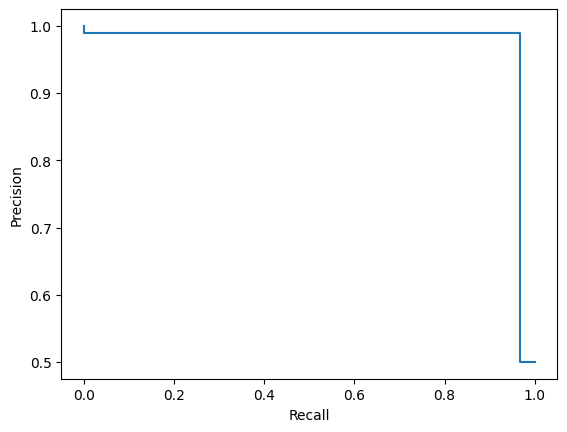

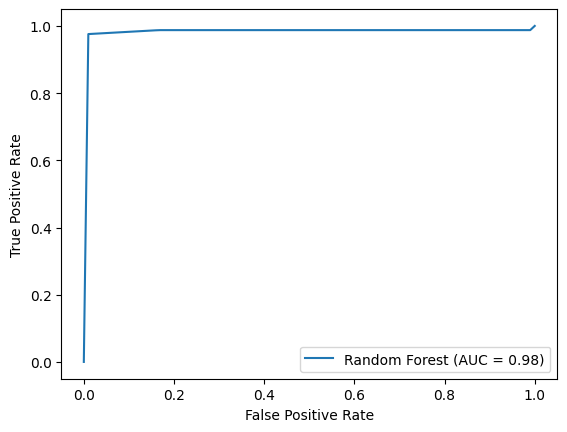

In [243]:
print(f"Least Empirical risk for rbf is {min(test_emp_risk_random_forest)} with number of estimators = { n_estimators[np.argmin(test_emp_risk_random_forest)]}")
print(f"Nested CV score for Random Forest: {rf_nested_cv}")
print(f"Random Forest f1 score: {rf_f1_score}")
display = PrecisionRecallDisplay(recall=rf_recall, precision=rf_precision)
display.plot()

rf_auc = auc(rf_fpr, rf_tpr)
roc_display = RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc = rf_auc, estimator_name="Random Forest").plot()

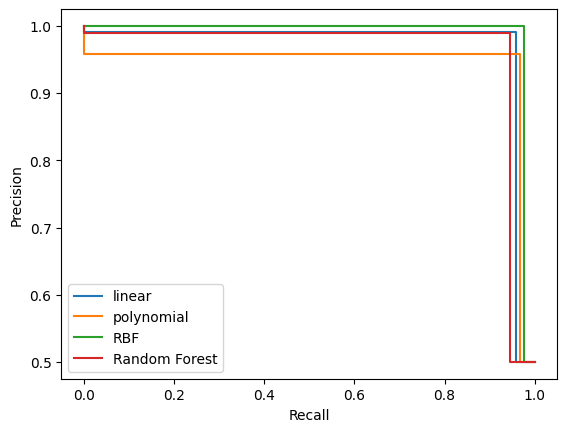

In [ ]:
ax = plt.gca()
display_lin = PrecisionRecallDisplay(recall=lin_recall, precision=lin_precision)
display_poly = PrecisionRecallDisplay(recall=poly_recall, precision=poly_precision)
display_rbf = PrecisionRecallDisplay(recall=rbf_recall, precision=rbf_precision)
display_rf = PrecisionRecallDisplay(recall=rf_recall, precision=rf_precision)

display_lin.plot(ax=ax, alpha=1, name="linear")
display_poly.plot(ax=ax, alpha=1, name="polynomial")
display_rbf.plot(ax=ax, alpha=1, name="RBF")
display_rf.plot(ax=ax, alpha=1, name="Random Forest")
plt.show()

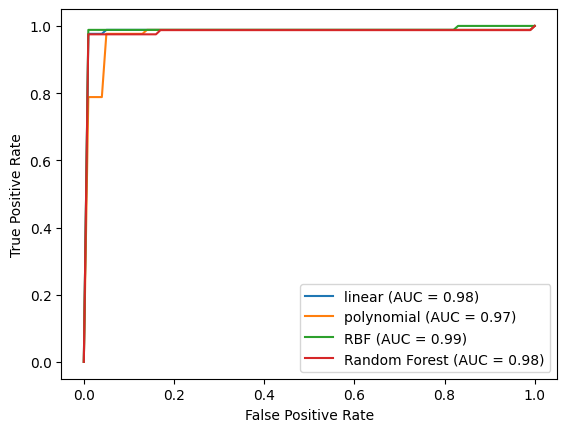

In [ ]:
ax = plt.gca()
roc_display_lin = RocCurveDisplay(fpr=lin_fpr, tpr=lin_tpr, roc_auc = lin_auc).plot(ax=ax, alpha=1, name="linear")
roc_display_poly = RocCurveDisplay(fpr=poly_fpr, tpr=poly_tpr, roc_auc = poly_auc).plot(ax=ax, alpha=1, name="polynomial")
roc_display_rbf = RocCurveDisplay(fpr=rbf_fpr, tpr=rbf_tpr, roc_auc = rbf_auc).plot(ax=ax, alpha=1, name="RBF")
roc_display_rf = RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc = rf_auc).plot(ax=ax, alpha=1, name="Random Forest")
plt.show()